# Crash course in Sobolev Spaces

In [1]:
%matplotlib inline
import dolfin as df
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from utils import x, y, z
import utils

df.set_log_level(30)

## Exercise 1

The $L^2$ norm of $u$ is given by

$$
    ||u||_{L^2} = \left( \int_\Omega |u|^2 \,\mathrm{d} x \right)^{1/2} .
$$

Implementation of a $L^2$-norm:

In [2]:
# %load -s L2_norm utils.py
def L2_norm(u):
    f = u*u
    I = df.assemble(f*df.dx)
    return df.sqrt(I)


The $H^1$ norm of $u$ is given by

$$
    ||u||_{2, 1} = \left( \int_\Omega |u|^2 + |\nabla u|^2 \,\mathrm{d} x \right)^{1/2} .
$$

Implementation of a $H^1$-norm:

In [3]:
# %load -s H1_norm utils.py
def H1_norm(u):
    f = u*u + df.inner(df.grad(u), df.grad(u))
    I = df.assemble(f*df.dx)
    return df.sqrt(I)


Using the function

$$
    \psi(x) = \sqrt{2}\cos(\pi x),
$$
which is normalized on the unit interval.

The $H^1$ norm is in this case should be

$$
    ||\psi||_{2, 1} = \sqrt{1 + \pi^2} .
$$

This is approximately

In [4]:
print(f"H1 should be {float(sp.sqrt(1 + sp.pi**2)):.6g}")

H1 should be 3.29691


Using the numerical functions:

In [5]:
f = utils.to_expression(sp.sqrt(2)*sp.cos(sp.pi*x))

for N in (10, 100, 1000):
    mesh = df.UnitIntervalMesh(N)
    V = df.FunctionSpace(mesh, "Lagrange", 1)
    u = df.interpolate(f, V)
    print(f"N is {N:4d} ->  L2: {L2_norm(u):6.4g} & H1: {H1_norm(u):6.4g}")

N is   10 ->  L2: 0.9918 & H1:  3.282
N is  100 ->  L2: 0.9999 & H1:  3.297
N is 1000 ->  L2:      1 & H1:  3.297


## Exercise 2

Now using

$$
    \psi(x) = \sin(k \pi x) .
$$

The $L^2$ norm is then
$$
    ||\psi||_{L^2} = \frac{1}{\sqrt{2}} ,
$$

and the $H_1$ is

$$
    ||\psi||_{2, 1} = \frac{k \pi}{\sqrt{2}}.
$$

For $k = 1, 10, 100$, this gives: 

In [6]:
L2 = 1/np.sqrt(2)
for k in (1, 10, 100):
    H1 = k*np.pi/np.sqrt(2)
    print(f"k is {k:4d} ->  L2: {L2:6.4g} & H1: {H1:6.2f}")

k is    1 ->  L2: 0.7071 & H1:   2.22
k is   10 ->  L2: 0.7071 & H1:  22.21
k is  100 ->  L2: 0.7071 & H1: 222.14


The numerical equivalent is given below.

In [7]:
N = 1000

mesh = df.UnitIntervalMesh(N)
V = df.FunctionSpace(mesh, "Lagrange", 1)
for k in (1, 10, 100):
    psi = utils.to_expression(sp.sin(sp.pi*k*x))
    u = df.interpolate(psi, V)
    print(f"k is {k:4d} ->  L2: {L2_norm(u):6.4f} & H1: {H1_norm(u):6.2f}")

k is    1 ->  L2: 0.7071 & H1:   2.33
k is   10 ->  L2: 0.7070 & H1:  22.22
k is  100 ->  L2: 0.7013 & H1: 221.23


The accuracy of the norms depends heavily on the mesh.

## Exercise 3

Using the piecewise function

$$
    \psi(x) =
    \begin{cases}
        10(x - 0.2) \quad \text{if  } 0.2 \leq x < 0.3 \\
        10(0.4 - x) \quad \text{if  } 0.3 \leq x < 0.4 \\
        0  \quad\quad\quad\quad\quad\quad  \text{otherwise}\\
    \end{cases} .
$$

Implementation of general function below:

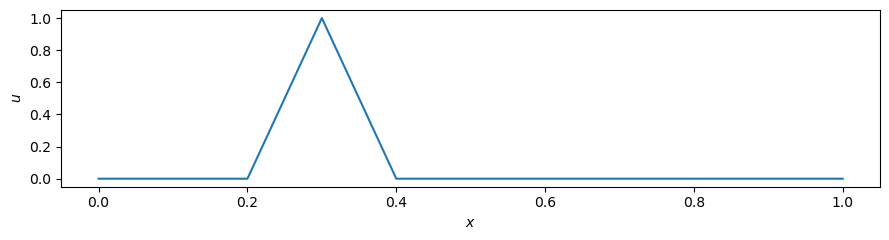

In [19]:
class Hat(df.UserExpression):
    def __init__(self, h, x0=0.5, **args):
        self.x0 = x0     # Location of peak
        self.xl = x0 - h # Left side
        self.xr = x0 + h # Right side
        self.h = h
        super().__init__(**args)
    
    def eval(self, values, x):
        if self.xl <= x[0] < self.x0:
            values[0] = (x[0] - self.xl)/self.h
        elif self.x0 <= x[0] < self.xr:
            values[0] = (self.xr - x[0])/self.h
        else:
            values[0] = 0
            
    def value_shape(self):
        return ()
    
    def interpolate(self, N):
        mesh = df.UnitIntervalMesh(N)
        V = df.FunctionSpace(mesh, "Lagrange", 1)
        return df.interpolate(self, V)
    
hat = Hat(0.1, x0=0.3)
plt.figure(0, figsize=(9, 2.5))
df.plot(hat.interpolate(350))
plt.xlabel(f"$x$")
plt.ylabel(f"$u$")
plt.tight_layout()
plt.show();

The norms are then:

In [20]:
for N in (10, 100, 1000):
    u3 = hat.interpolate(N)
    print(f"N is {N:4d} ->  L2: {L2_norm(u3):6.5g} & H1: {H1_norm(u3):6.5g}")

N is   10 ->  L2: 0.2582 & H1: 4.4796
N is  100 ->  L2: 0.2582 & H1: 4.4796
N is 1000 ->  L2: 0.2582 & H1: 4.4796


## Exercise 4


The piecewise function from E3 is now positioned at $x_m$ with width $2 h$:

$$
    \psi(x; x_m, h) =
    \begin{cases}
        {(x - x_l)}/{h} \quad \text{if  } x_l \leq x < x_m \\
        {(x_r - x)}/{h} \quad \text{if  } x_m \leq x < x_r \\
        0  \quad\quad\quad\quad\quad\quad  \text{otherwise}\\
    \end{cases} ,
$$

where $x_l = x_m - h$ and $x_l = x_m + h$.

We can see that the function approaches the Dirac delta function in the limit $\lim_{h \to 0} \psi(x; x_m, h) = \delta (x - x_m)$.

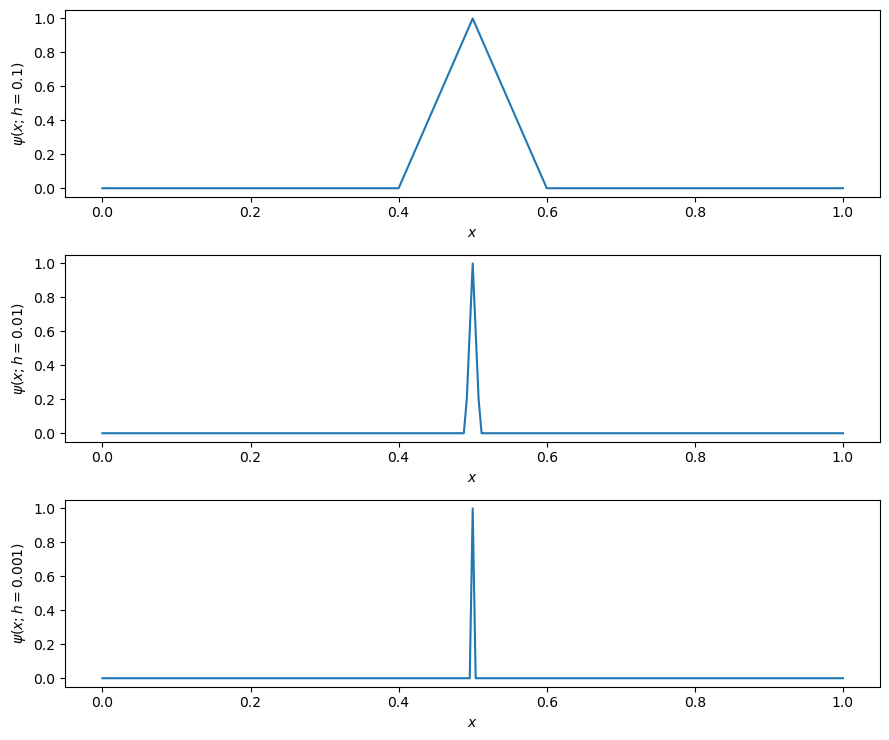

In [21]:
N = 250
plt.figure(1, figsize=(9, 7.5))
for i, h in enumerate([0.1, 0.01, 0.001]):
    plt.subplot(311 + i, xlabel=r"$x$", ylabel=r"$\psi(x; h=%g)$"%h)
    df.plot(Hat(h).interpolate(N))
plt.tight_layout()
plt.show();

The $L^2$ norm can be computed as

$$
    ||\psi(x; x_m, h)||_{L^2} = \left(\int_{x_m - h}^{x_m + h}\psi(x; x_m, h)^2 \,\mathrm{d}x\right)^{1/2}
        = \left(\int_{-h}^{h}\psi(x; 0, h)^2 \,\mathrm{d}x\right)^{1/2}
        = \left(2\int_{0}^{h}\psi(x; 0, h)^2 \,\mathrm{d}x\right)^{1/2},
$$

where I have shifted the integral by $x_m$ and used the symmetry of the cone. The $L^2$ norm is then

$$
    ||\psi(x; x_m, h)||_{L^2} = \left(\frac{2}{h^2}\int_{0}^{h}(h - x)^2 \,\mathrm{d}x\right)^{1/2}
                = \left(\frac{2}{h^2}\left[\frac{x^3}{3} - h x^2 + h^2 x\right]_{0}^{h}\right)^{1/2}
                = \sqrt{\frac{2 h}{3}}.
$$

Comparing with numerical results:

In [22]:
N = 500
for i, h in enumerate([0.1, 0.01, 0.001]):
    u4 = Hat(h).interpolate(N)
    print(f"h is {h:g}\n\tcomputed:   {L2_norm(u4):8.4g}\n\tanalytical: {np.sqrt(2*h/3):8.4g}")

h is 0.1
	computed:     0.2582
	analytical:   0.2582
h is 0.01
	computed:    0.08165
	analytical:  0.08165
h is 0.001
	computed:    0.03651
	analytical:  0.02582


The derivative of the function is


$$
    \frac{\mathrm{d}}{\mathrm{d} x}\psi(x; x_m, h) =
    \begin{cases}
        1/{h} \ \quad \text{if  } x_l \leq x < x_m \\
        -1/{h} \quad \text{if  } x_m \leq x < x_r \\
        0  \quad\quad\quad \text{otherwise}\\
    \end{cases} ,
$$

The integral over the derivative squared is 

$$
   \int_{x_m - h}^{x_m + h}\left|\frac{\mathrm{d}}{\mathrm{d} x}\psi(x; x_m, h)\right|^2 \,\mathrm{d}x
        = \int_{-h}^{h}\psi(x; 0, h)^2 \,\mathrm{d}x
        = \int_{-h}^{h}\frac{1}{h^2} \,\mathrm{d}x = \frac{2}{h} .
$$


The $H_1$ is then given by

$$
    ||\psi(x; x_m, h)||_{2, 1} = \left(||\psi(x; x_m, h)||_{2}^2 
    + \int_{x_m - h}^{x_m + h}\left|\frac{\mathrm{d}}{\mathrm{d} x}\psi(x; x_m, h)\right|^2\,\mathrm{d}x\right)^{1/2}
    = \left(\frac{2 h}{3} + \frac{2}{h}\right)^{1/2}
$$

In [26]:
N = 1000
for i, h in enumerate([0.1, 0.01, 0.001]):
    u4 = Hat(h).interpolate(N)
    print(f"h is {h:g}\n\tcomputed:   {H1_norm(u4):8.4g}\n\tanalytical: {np.sqrt(2*h/3 + 2/h):8.4g}")

h is 0.1
	computed:       4.48
	analytical:     4.48
h is 0.01
	computed:      14.14
	analytical:    14.14
h is 0.001
	computed:      44.72
	analytical:    44.72


The $H^{-1}$ of $f$ is given by

$$
    ||f||_{H^{-1}} = ||\nabla^{-1} f||_{L^2} .
$$

The solution can be found using the Poisson problem

$$
    -\Delta u = f
$$

with homogenious Dirichlet boundary conditions. We then have that $-\nabla u = \nabla^{-1}f$, which leads to final expression for the $H^{-1}$ norm:

$$
    ||f||_{H^{-1}} = || \nabla u||_{L^2} =  |u|_{H^1}.
$$

Implementation of the $H^{-1}$ norm:

In [27]:
def Hinv_norm(f, order=1, N=32, space="Lagrange"):
    mesh = df.UnitIntervalMesh(N)
    V = df.FunctionSpace(mesh, space, order)
    psi = df.TrialFunction(V)
    phi = df.TestFunction(V)
    u = df.Function(V)
    boundary = lambda x, on_boundary: on_boundary
    
    bc = df.DirichletBC(V, 0, boundary)
    a = df.inner(df.grad(psi), df.grad(phi))*df.dx
    L = f*phi*df.dx
    df.solve(a == L, u, bc)
    
    # norm
    g =  df.inner(df.grad(u), df.grad(u))
    I = df.assemble(g*df.dx)
    return df.sqrt(I)

First just testing with $f = \sin(\pi k x)$. We then have that $u(x) = \frac{\sin(k\pi x)}{(k \pi)^2}$, which means that  $u_x(x) = \frac{\cos(k\pi x)}{k \pi}$. The $H^{-1}$ norm should therefore be $\frac{1}{\sqrt{2}k \pi}$.

In [28]:
for k in (1, 10, 100):
    psi = utils.to_expression(sp.sin(sp.pi*k*x))
    exact = 1/(k*np.pi*np.sqrt(2))
    print(f"k is {k:4d} ->  H(inv): {Hinv_norm(psi, order=1, N=1000):9.4g} ({exact:.4g})")

k is    1 ->  H(inv):    0.2251 (0.2251)
k is   10 ->  H(inv):   0.02251 (0.02251)
k is  100 ->  H(inv):  0.002242 (0.002251)


Finally, the $H^{-1}$ of $\psi(x; x_m, h)$ is:

In [29]:
N = 1000
for h in [0.1, 0.01, 0.001]:
    print(f"h is {h:5.1g} ->  H(inv): {Hinv_norm(Hat(h), order=1, N=N):9.6f}.")

h is   0.1 ->  H(inv):  0.047609.
h is  0.01 ->  H(inv):  0.004977.
h is 0.001 ->  H(inv):  0.000500.


## Exercise 5

Considering the Hilbert function space $H^1(\Omega)$, with the norm defined as 

$$
    ||u||_{H^1(\Omega)} = \left( \int_\Omega |u|^2 + |\nabla u|^2 \,\mathrm{d} x \right)^{1/2} 
    = \left(||u||_{L^2 (\Omega)}^2 + |u|_{H^1(\Omega)}^2\right)^{1/2}.
$$

The second expression uses the corresponding semi-norm $|u|_{H^1(\Omega)}$ and the $L^2(\Omega)$ norm.


Introducing the subspace $H^1_0(\Omega)$, fulfilling homogeneous Dirichlet boundary conditions. Poincaré's inequality states that there exists a positive constant $C$ such that

$$
    ||u||_{L^2(\Omega)} \leq C ||\nabla u||_{L^2(\Omega)} = C  |u|_{H^1(\Omega)},
$$

for all functions in $H^1_0(\Omega)$.

Since all norms and $C$ must be positive, we may square the inequality, yielding 
$||u||_{L^2(\Omega)}^2 \leq C^2 |u|_{H^1}^2$.
This further means that

$$
    ||u||_{H^1(\Omega)}^2 \leq (C^2 + 1)|u|_{H^1}^2 .
$$

Also, since $||u||_{L^2 (\Omega)}^2 \geq 0$, then we must have that 
$||u||_{H^1(\Omega)} \geq |u|_{H^1}$.


Using this, we can see that the $H^1$ norm and semi-norm are equivalent, as 

$$
    |u|_{H^1} \leq ||u||_{H^1(\Omega)} \leq \sqrt{C^2 + 1}|u|_{H^1},
$$

for all functions $u$ in $H^1_0$.